# Example on how to use of regenie for single variant analysis of exome data

## Introduction

[Regenie](https://rgcgithub.github.io/regenie/) is a program that performs genome-wide association analysis in very large datases such as the UK Biobank.

## Properties

1. Works with quantitative and binary traits (case-control), including those with unbalanced samples case-control ratio. Supports Firth logistic regression and SPA for binary traits.
2. Uses linear mixed models (LMM) for quantitative traits and generalized LMM (GLMM) for binayr traits, allowing for the inclusion of related individuals. 
3. Offers the advantage of processing multiple phenotypes at the same time. However you should be aware that quantitave or binary traits need to be analyzed separately. Also, the proportion of missing data should be similar for all of the traits analyzed at once, since it can impact predictions. Authors of regenie recommend to analyze traits in groups that have similar missingness patterns with resonably low amount of missingness (<15%).
4. It can handle different types of data (microarray, imputed, exome sequencing) and formats (PLINK:bed/bim/fam, PLINK2:pgen/pvar/psam and BGEN).
5. It is desgined to handle a large number of samples ~500K. Regenie is not appropiate to analyze small samples
6. Integrates covariates into the model.

## Method

Regenie works in two different steps that are independent from each other. 

### Step 1. 

The first step is where it fits the null regression model, for this regenie uses a subset of genetic markers that capture a good proportion of the phenotype variance that is attributable to genetic effects

- Level 0: Ridge regression applied to block of SNPs to reduce dimensions
- Level 1: Linear or logistic ridge regressions within cross validation scheme

### Step 2.

A larger set of genetic markers is used to test for association, using a linear or logistic regression, with the traits conditional upon the prediction from the regression model on step 1. This is done by using the Leave One Chromosome Out (LOCO) scheme to avoid proximal contamination. 

## Toy dataset

For this exercise we will use data from 1000G pubicly available database.The populations in the dataset are GBR=82, FIN=99 and TSI=104.

Please note that this is only an example dataset for real life applications a much larger sample size is necessary. Also due to the use of different populations the use of principal components may be necessary to avoid increased type I error. 

```
1000G.EUR.fam
1000G.EUR.bim
1000G.EUR.bed
```

## Phenotype file

For the 1000G data there is not phenotype data available. Therefore we have create a  disease x phenotype by randomly assigning study subjects as cases and controls. Therefore the data is generated under the null of no association. 

## Genotype file 

For this example we are providing you with a genotype file that has been pruned and filtered using some quality control criteria. 

## Runing the single variant association analysis

**1. Prepare the data**

In this example, we are going to use a subset of genetic markers from the data to fit the null model of step 1. 

This process has been already integrated in the [LMM pipeline](https://github.com/cumc/bioworkflows/blob/master/GWAS/LMM.ipynb) under the `regenie_qc` step. It is recommended to use the data from the genotype array in this step, as it provides better estimates of the phenotype variance. 

Note: make sure you don't have any SNVs with a very low minor allele count (MAC) for the single variant analysis, otherwise regenie will give an error message. 

Let the parameters for the initial quality control be:

- maf_filter=0.01, we will keep only variant with MAF >1%
- geno_filter=0.1, we will remove variants with > 10% genotypes missing
- mind_filter=0.1, we will remove individals with > 10% genotypes missing 
- hwe_filter=5e-08, we will remove variants exceding a p-value for HWE > 5E-08

The output produced in this part consist of two files:

`1000G.EUR.mini.qc_pass.id` and `1000G.EUR.mini.qc_pass.snplist`, these contain the list of individuals and variants to keep in the step 1 of regenie. 

In this MWE we keep n=32,254 variants and n=489 samples that pass our QC filters. 


**2. Fitting the null**

In this step, we will use the genotype file (that has been pruned and filtered previously) and we will tell regenie which samples and variants to keep based on the results of our QC. 

- bfile=1000G.EUR.filtered.pruned.bed, we will use a subset of the genotyped genetic markers to calculate the predictions. This file has been pruned using a window size of 100, step of 10 and a r^2 of 0.04.
- block_size=1000 this will tell the program in how many "chunks" to divide the genotype file to make predictions

The output produced in this step correspond to: 

- A set of files (depending on the number of phenotypes analyzed) containing genomic predictions for each phenotype from Step 1 `1000G.EUR.pheno_x.regenie_1.loco`
- A file called `1000G.EUR.pheno_x.regenie_pred.list` listing the locations of the prediction files

**3. Association analysis**

In this step, namely step 2 of regenie, it will perform the single variant association analysis with each of the phenotypes. 

Note: a convenient quality of REGENIE is that step 1 and 2 are decoupled meaning that you can use all of the traits used in step 1 or just a subset of them for the association analysis. Also, you can test the association using array, exomed or imputed variants. 

For this example, we will use our phenotype for disease x with the following parameters:

- trait='bt' Here you define whether your trait is binary of quantitative.
- covarCol=sex. In our particular case we will only use sex as covariate. However, if you have more than one covariate you can input them here separeted by comma
- qCovarCol We will leave this variable empty in our analysis, but as above you can give a list of quantitative variables. 
- minMac=5 this flag is used to tell the program which minimum minor allele count (MAC) to use when testing variants, default value is 5. 

Depending on the type of data you are using, there are other useful parameters that you can explore. For example, with imputed data you may want to set the minimum info score to use (`--minINFO`), with quantitative phenotypes you may choose to use an inverse rank normalization (`--apply-rint`), for binary traits you can decide whether to use Firth (`--firth`) or Saddle Point Approximation (`--spa`) corrections.

The output produced in this step corresponds to:

- Summary statistics in a file with `*.regenie` extension, if option `-gz` was used this files will be compressed `*.regenie.gz`

## Cloning bioworkflows repo

First of all, you will need to have `git` installed in your local computer and then clone the repository where the pipeline that is going to be used for this tutorial is located

```
cd ~/
git clone https://github.com/cumc/bioworkflows.git
```

### REGENIE example command
On a minimal working example (MWE) dataset

Because step 1 (fitting the null) is the most time consuming in Regenie, it takes about ~15 minutes for this MWE (including the QC). We are proving in the output_burden folder the already generated files for this step. To start running from step 2 (the association analysis, that takes ~3 minutes) you only need to specify `-s build` in sos command line, so that those first steps are not run again. 

In [ ]:
sos run ~/bioworkflows/GWAS/LMM.ipynb regenie \
    --cwd ~/MWE_regenie/output \
    --bfile ~/MWE_regenie/data/1000G.EUR.pruned.bed \
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile ~/MWE_regenie/data/1000G.EUR.bed \
    --phenoFile ~/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/MWE_regenie/data/regenie_template.yml\
    --phenoCol x\
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 5 \
    --reverse_log_p \
    --p-filter 1 \
    --label_annotate SNP\
    -s build


#### Manhattan plot

> /home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan.png (209.9 KiB):

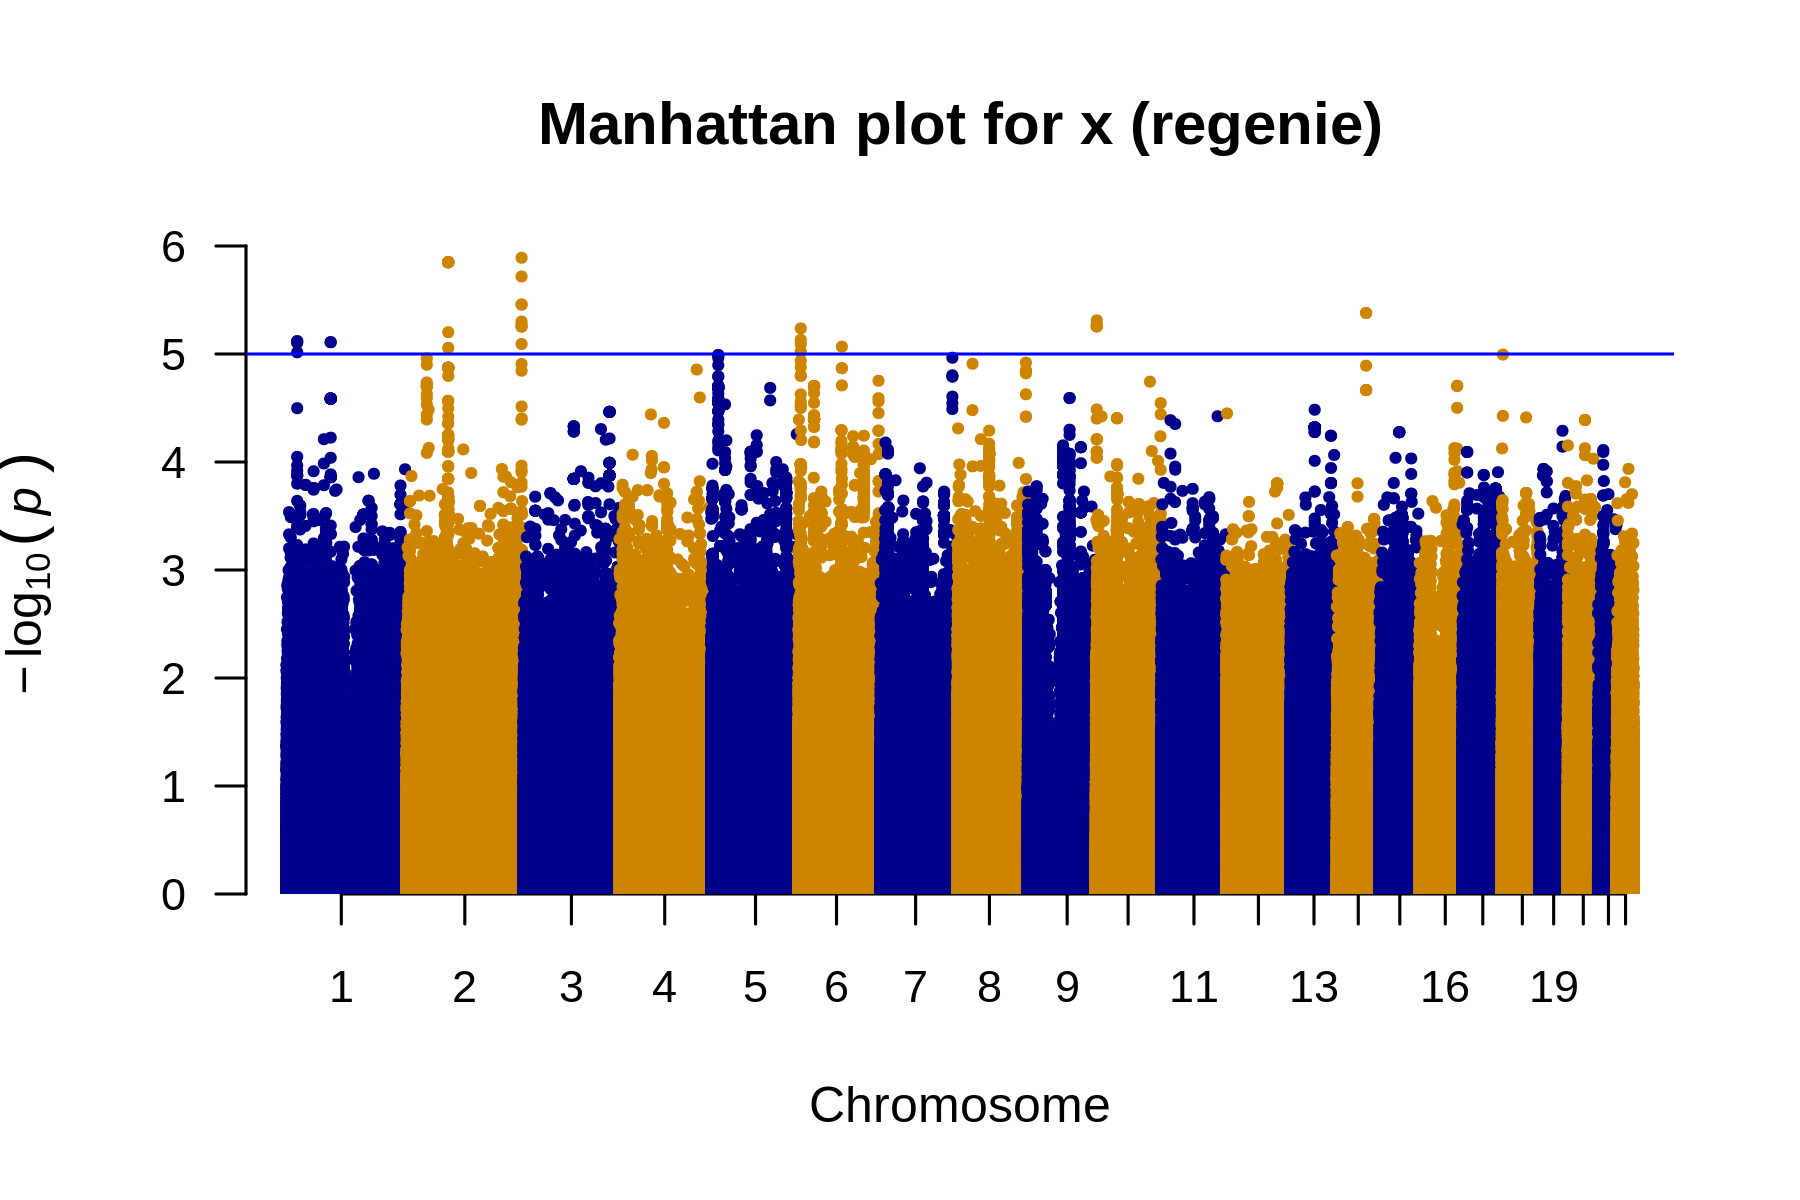

>>> ~/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan.png:

bash: /home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan.png: Permission denied



In [3]:
%preview -s png ~/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan.png

#### Q-Q plot

> /home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.qq.png (77.0 KiB):

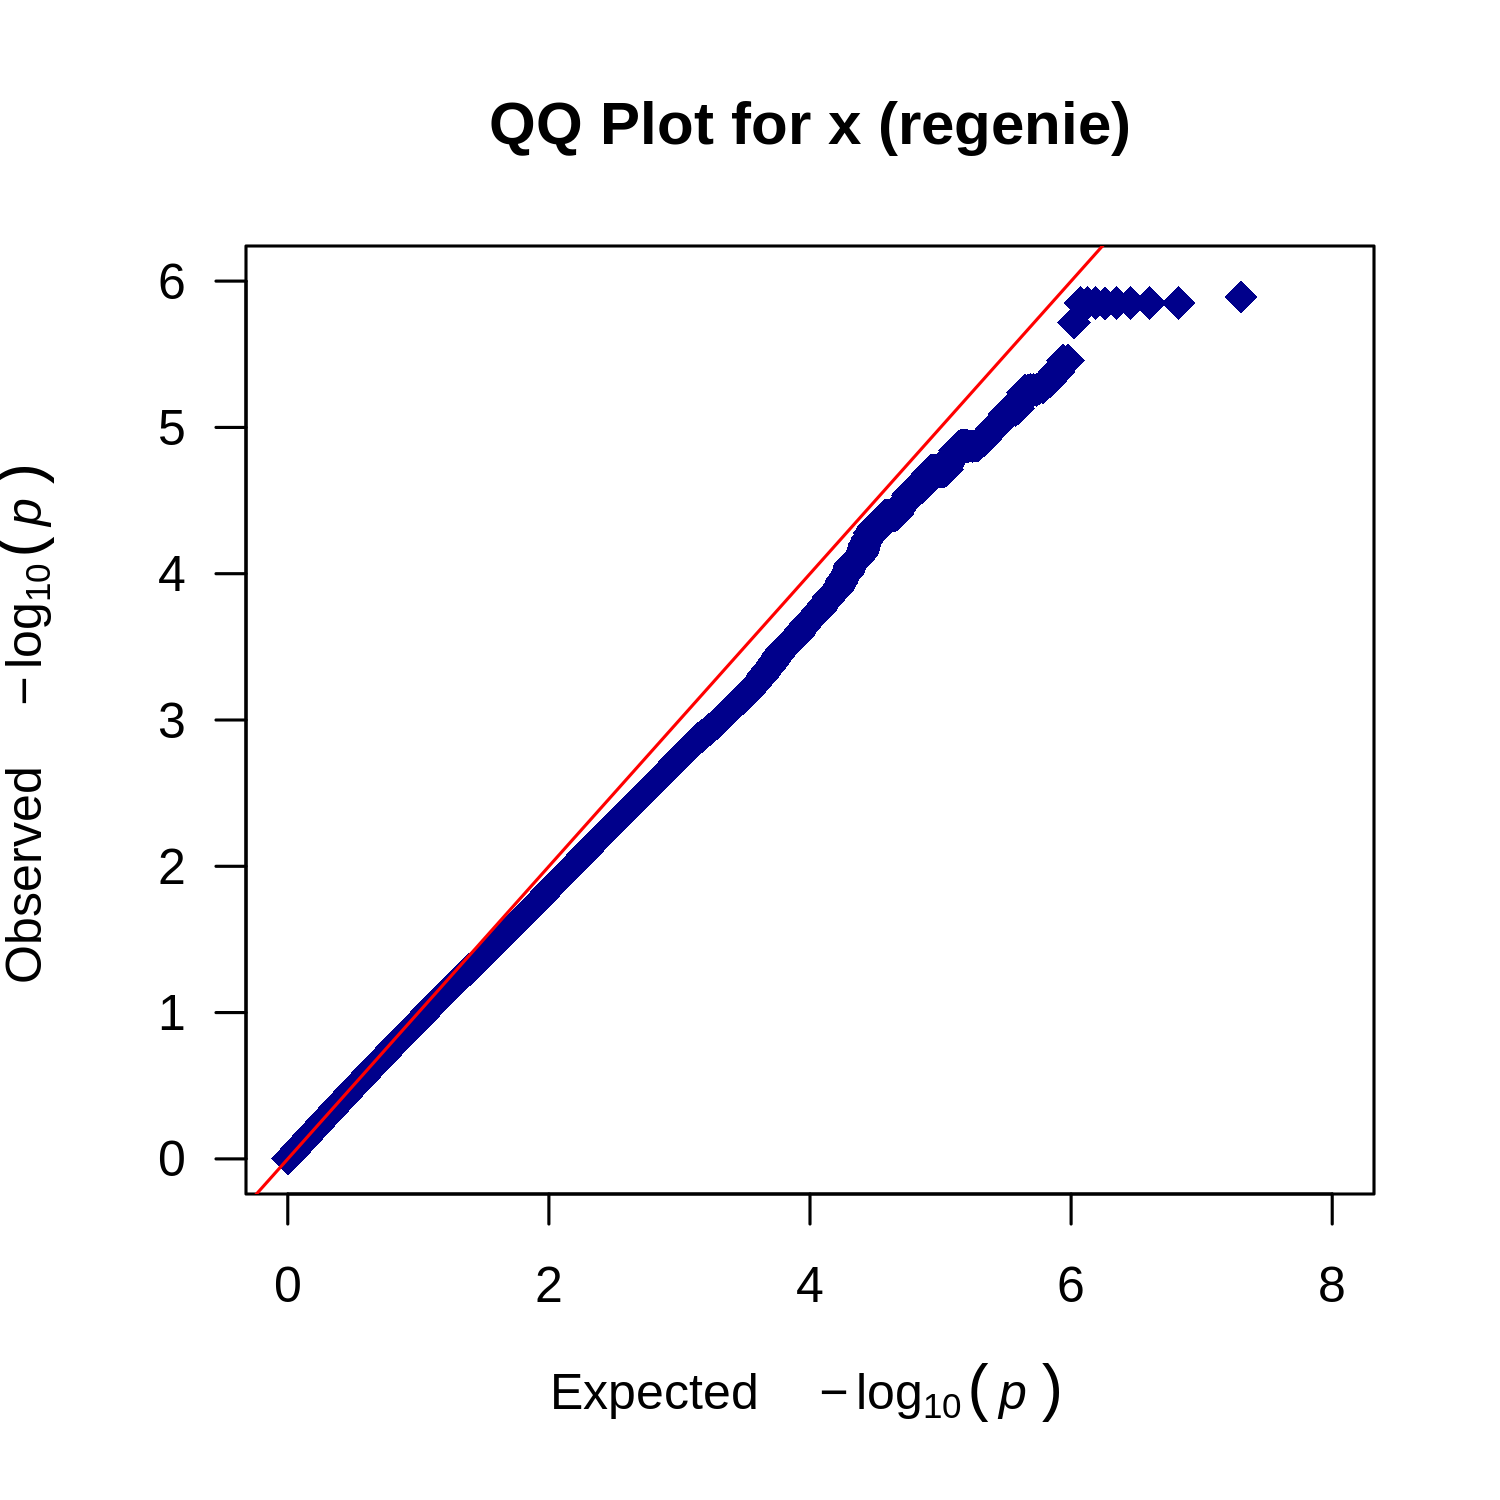

In [4]:
%preview -s png ~/MWE_regenie/output/1000G.EUR.pheno_x.regenie.qq.png

#### Lambda GC value

In [6]:
cat ~/MWE_regenie/output/1000G.EUR.pheno_x.regenie.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# x result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240

```
## p-value summary:
Genomic inflation factor is 0.943 for 9997231 variants analyzed.

---

# QQ plot for x

![](1000G.EUR.pheno_x.regenie.qq.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan_annotated.png)

---

# Manhattan plot for x

![](1000G.EUR.pheno_x.regenie.manhattan_annotated.svg)

---

# Result files
```
/home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.analysis_summary.md
/home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.log
/home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan.png
/home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhattan_annotated.pdf
/home/dmc2245/MWE_regenie/output/1000G.EUR.pheno_x.regenie.manhatta

## Runing the burden test

Regenie offers the functionality of performing rare-variant aggregate association analysis in the form of burden tests.  

You can combine rare-variants in a gene or a region, using functional annotations to create masks that are then tested for association (as in a single variant analysis) with a phenotype. 

Input files:

1. You will need to provide an annotation file that is formatted: variant_id, gene/region, functional annotation (e.g. LoF, missense). You can use VEP or ANNOVAR to generate this information and then format it accordingly. 
2. Provide the set-list-file: this file contains a list of variants within each gene/region that's used when building the masks. The format is: gene/region name, chromosome, start_position, list of variants in the gene/region separated by comma. 
3. Optional: provide a file with genes/regions that you want to include or exclude from your analysis.
4. Optional: provide an allele-frequency file to use when creating the masks. By default the allele frequency is computed from the sample. In our case we are providing a allele-frequency file, obtained from gnomAD. In this case we used the AF_nfe field which contains the allele frequencies for non Finnish Europeans available in gnomAD. 
5. Mask file: this is a text file that contains the name of the mask and the type of annotations to use when building it (one mask per line). E.g. 

```
mask1 LoF,missense
```

6. You need to provide the `--aaf-bins` cut-off in the parameters. This refers to the AAF upper bounds to use when creating the masks. By default regenie_burden produces results for singletons and if you set `--aaf-bins` to be for example 0.01 it will create masks from  [0,0.01] and singletons. 

Additionally, you can choose the way the mask are built among these options:
- using the maximum number of ALT alleles across sites ('max'; the default)
- using the sum of ALT alleles ('sum')
- using a maximum threshold of 2 ('comphet')

![Rules to build mask](https://rgcgithub.github.io/regenie/img/mask_rules.png)


For this MWE we have already generated the annotation, the set list, the allele frequency and the mask files that are provided in the annotation folder. 

### Regenie burden example command

Because step 1 (fitting the null) is the most time consuming in Regenie, it takes about ~15 minutes for this MWE (including the QC). We are proving in the output_burden folder the already generated files for this step. To start running from step 2 (the association analysis, that takes ~3 minutes) you only need to specify `-s build` in sos command line, so that those first steps are not run again. 

In [ ]:
sos run ~/bioworkflows/GWAS/LMM.ipynb regenie_burden \
    --cwd ~/MWE_regenie/output_burden \
    --bfile ~/MWE_regenie/data/1000G.EUR.pruned.bed \
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile ~/MWE_regenie/data/1000G.EUR.bed \
    --phenoFile  ~/MWE_regenie/data/1000G.EUR.pheno.x \
    --formatFile ~/MWE_regenie/data/regenie_template.yml\
    --phenoCol x\
    --covarCol sex \
    --qCovarCol \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 1 \
    --reverse_log_p \
    --p-filter 1 \
    --label_annotate SNP\
    --anno_file ~/MWE_regenie/data/*.anno_file\
    --aaf_file ~/MWE_regenie/data/*.aff_file\
    --set_list ~/MWE_regenie/data/*.set_list_file\
    --mask_file ~/MWE_regenie/data/*.mask_file\
    --snpannofile ~/MWE_regenie/data/1000G.EUR.hg19.hg19_multianno_filtered.csv\
    --build_mask max\
    --aaf_bins  0.01\
    -e ignore\
    -s build

### Output files

After running regenie burden you will find the following output files:

* `1000G.EUR.pheno_x.regenie_burden.mask1.0.01.snp_stats.gz` This file contains the results only for mask1 and 0.01 bin
* `1000G.EUR.pheno_x.regenie_burden.mask1.0.01.remove_sin.snp_stats.gz` In this file genes with only one rare variant have been removed (this is the one we are going use to make the manhattan plot)

After running this analysis you will see a warning in step regenie_burden_6 about some missing files. These files correspond to the singleton analysis, which for this MWE won't be generated. To ignore these errors we are adding the `-e ignore` in the example command, so that the pipeline can complete successfully. 

You will also see that both manhatttan and qq plots have been generated for mask1 with the 0.01 bin combination. 

### Manhattan plot

> /home/dmc2245/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.manhattan.png (225.0 KiB):

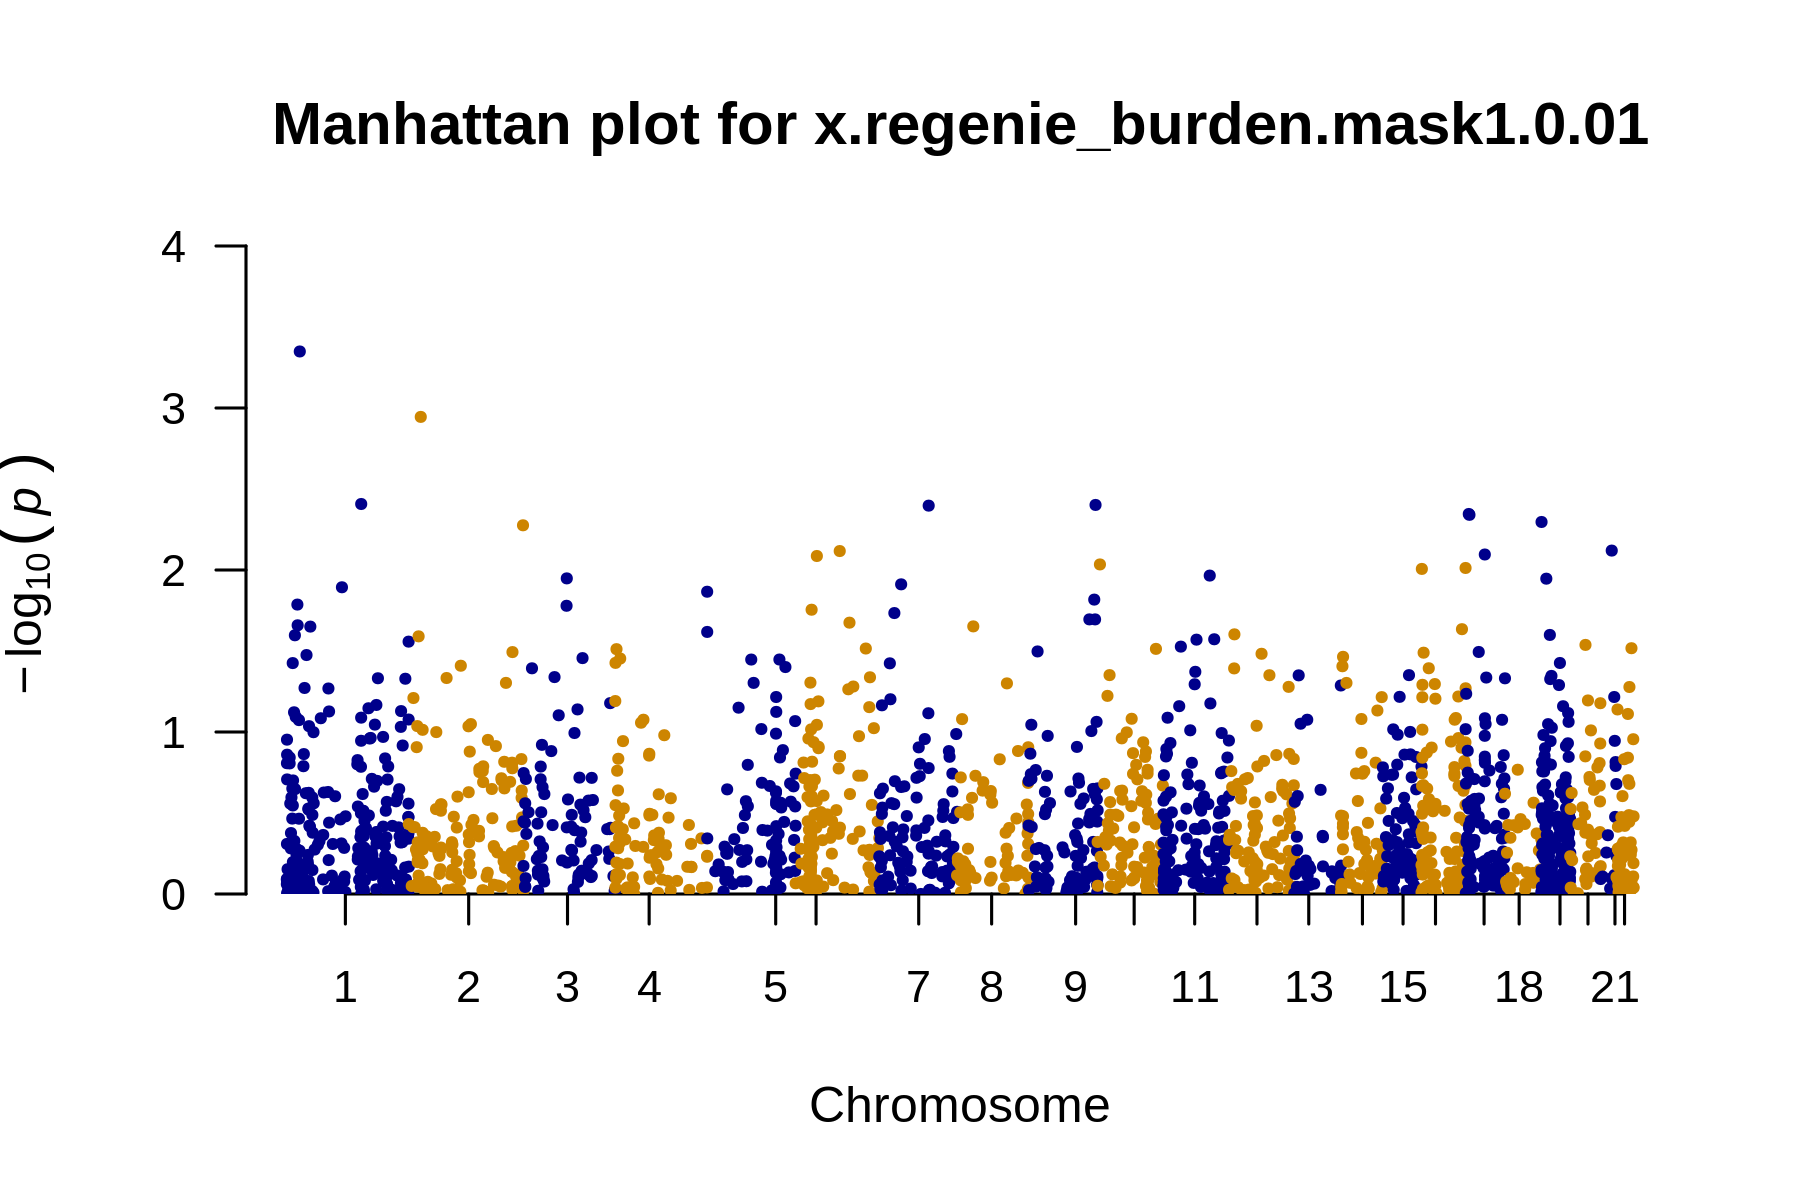

>>> ~/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.manhattan.png:

bash: /home/dmc2245/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.manhattan.png: Permission denied



In [14]:
%preview -s png ~/MWE_regenie/output_burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.manhattan.png

### Q-Q plot

> /home/dmc2245/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.qq.png (75.6 KiB):

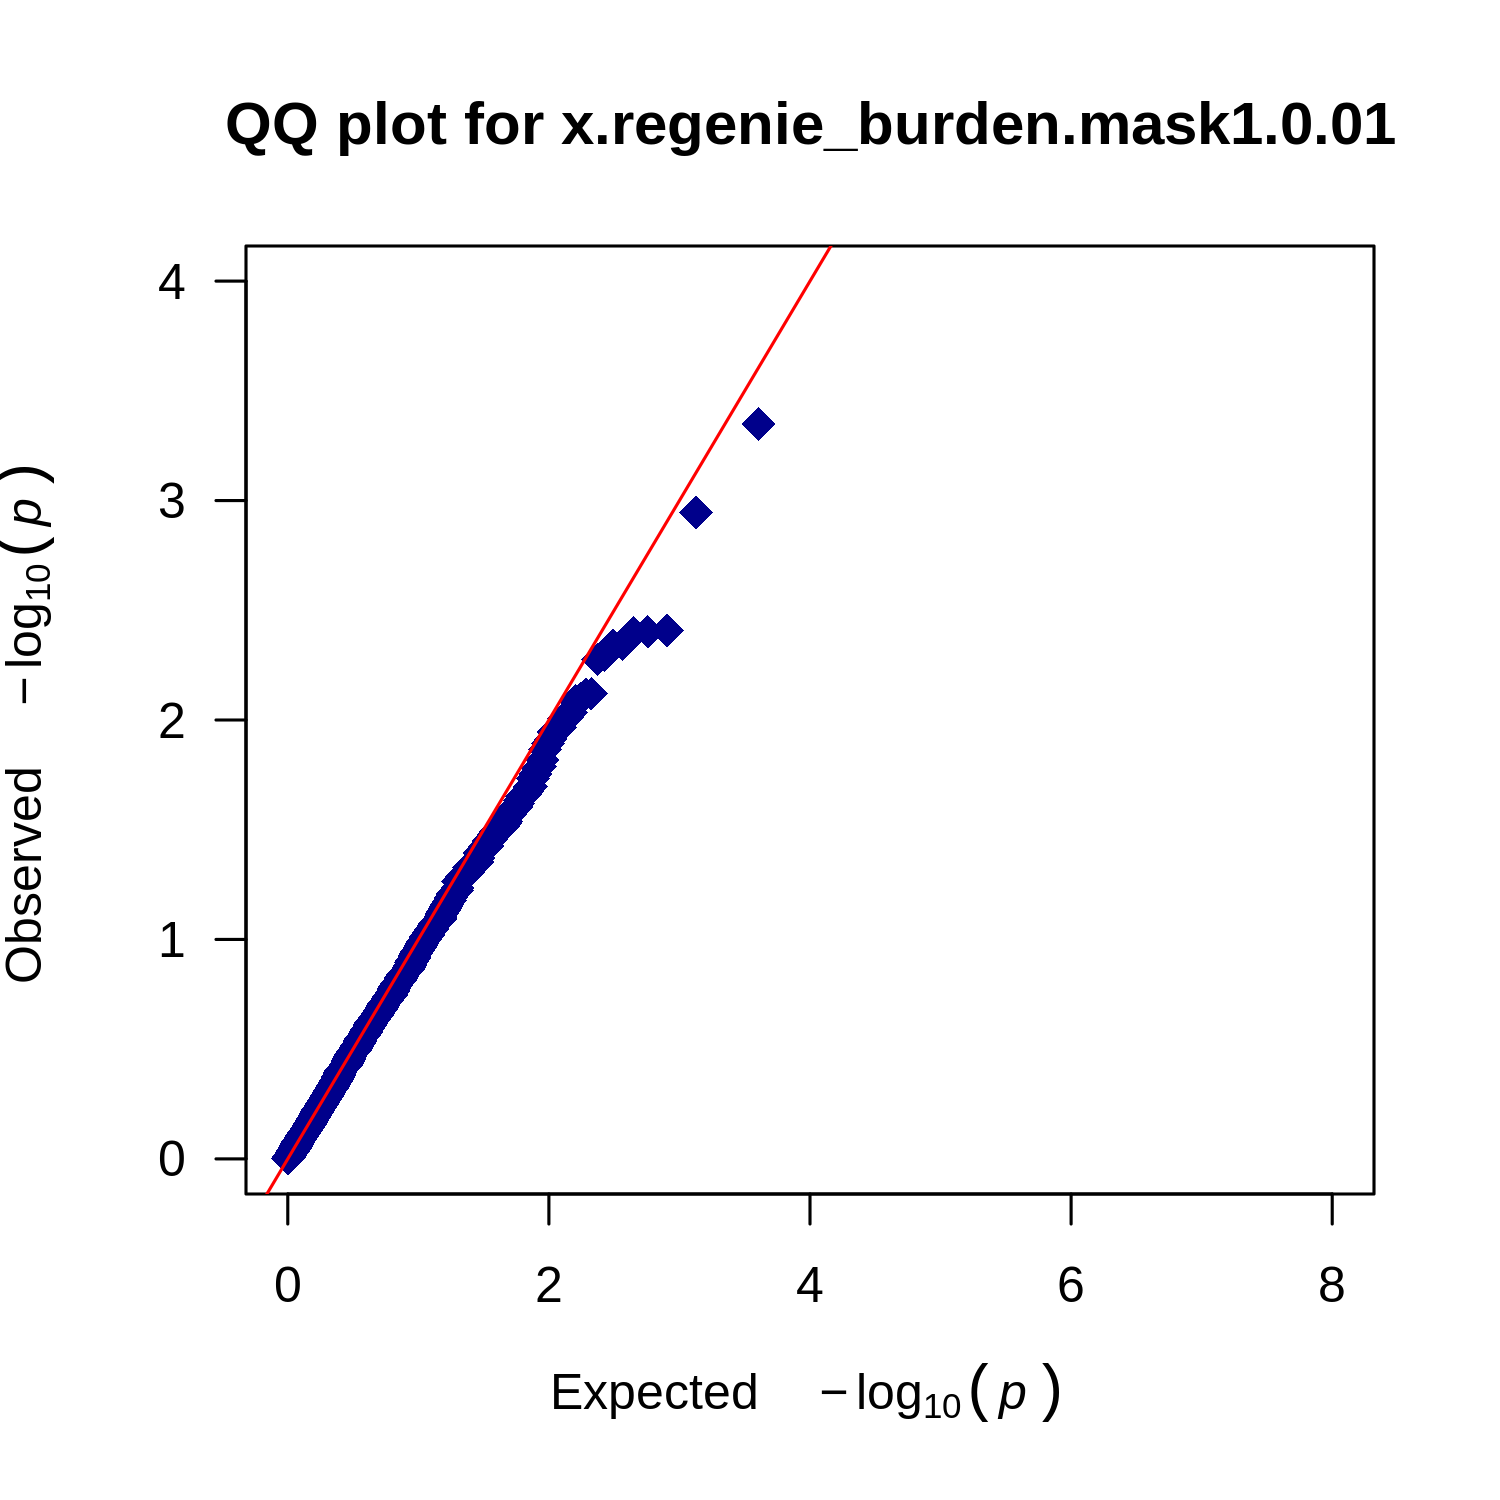

>>> ~/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.qq.png:

bash: /home/dmc2245/MWE_regenie/burden/output/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.qq.png: Permission denied



In [15]:
%preview -s png ~/MWE_regenie/output_burden/1000G.EUR.pheno_x.regenie_burden.mask1.0.01.qq.png